<a href="https://colab.research.google.com/github/ale-camer/Data-Science/blob/Finance/News_Articles_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages, functions and data

In [ ]:
!pip install unidecode --quiet

# packages
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# functions
def text_normalizer(df, column, language:str='english', minWordLen:int=2):
        
    """
    The objective of this function is to normalize text data. Therefore, it takes as inputs:
        
        - a Pandas Dataframe that must be specify in the input 'df',
        - the name of the column to normalize in the input 'column',
        - the language, in the input 'language', in which the articles were written, which by default is english,
        - and the minimum amount of words that must have a word, in the input 'minWordLen', which by default is 2.
    """

    import re
    import nltk
    import unidecode
    import pandas as pd
    from nltk.tokenize.toktok import ToktokTokenizer
    
    assert type(df) == pd.DataFrame, "The input 'df' must recieve a Pandas Dataframe"
    assert type(language) == str, "The input 'language' must be a string"
    assert type(minWordLen) == int, "The input 'minWordLen' must be an integer"

    nltk.download('stopwords', quiet=True) # download stopwords
    stopword_list = nltk.corpus.stopwords.words(language)
    
    def conti_rep_char(str1): 
        tchr = str1.group(0)
        if len(tchr) > 1:
          return tchr[0:1]
         
    def check_unique_char(rep, sent_text): 
         convert = re.sub(r'[^a-zA-Z0-9\s]',rep,sent_text) # regex to keep only words and numbers
         return convert
     
    tokenizer = ToktokTokenizer() # instantiation of tokenizer
    urlRegex = re.compile('http\S+') # regex for URL deletion
    stem = nltk.stem.SnowballStemmer(language=language) # intantiation of steming 
    
    columna = pd.DataFrame(df[column].apply(lambda a: ' '.join([word for word in a.lower().split() if word not in stopword_list]))) # lower capital letters and remove stopwords
    columna[column] = columna[column].apply(lambda a: check_unique_char(conti_rep_char, a)) # remove special characters
    columna[column] = columna[column].apply(lambda a: ' '.join([word for word in a.split() if not re.match(urlRegex, word)])) # remove URLs
    columna[column] = columna[column].apply(lambda a: ' '.join([word for word in a.split() if len(word) > minWordLen])) # keep only words of a given length
    columna[column] = columna[column].apply(lambda a: ' '.join([unidecode.unidecode(word) for word in a.split()])) # reemplaing diacritical marks 
    columna[column] = columna[column].apply(lambda a: ' '.join([stem.stem(word) for word in a.split()])) # steming
    columna[column] = columna[column].apply(lambda a: tokenizer.tokenize(a)) # tokenizing
    
    return columna[column]

def document_vectorizer(corpus, model, num_features:int=1000):

    """
    The objective of this function is to create features. Tharefore, it takes as inputs:

        - a dataset to featurize in the input 'corpus',
        - a model for featurization in the input 'model',
        - and the number of feature to generate in the input 'num_features'
    """
    
    import numpy as np

    assert type(num_features) == int, "The variable 'num_features' must be an integer"
    
    vocabulary = set(model.wv.index2word)
    def average_word_vectors(words, model, vocabulary, num_features):
      
        feature_vector = np.zeros((num_features,), dtype="float64") # empty numpy array
        nwords = 0.
    
        for word in words: # numpy array population
            if word in vocabulary:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
          feature_vector = np.divide(feature_vector, nwords)
        
        return feature_vector
    
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus] # features
    return np.array(features)

data = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers', 'quotes')) # download data
data = pd.DataFrame({'Article': data.data, 'Label': data.target}) # structure data
data

,Article,Label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4
...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13
18842,\nNot in isolated ground recepticles (usually ...,12
18843,I just installed a DX2-66 CPU in a clone mothe...,3
18844,\nWouldn't this require a hyper-sphere. In 3-...,1


## Preprocessing

In [ ]:
data['Clean Article'] = text_normalizer(df = data, column='Article') # normalize data
data['Clean Article Length'] = data['Clean Article'].apply(lambda a: len(a)) # create variable to remove empty normalized data
data = data[(~(data.Article.str.strip() == "")) & (data['Clean Article Length'] != 0)].drop('Clean Article Length',axis=1).reset_index(drop=True) # remove empty articles and normalized data
data

,Article,Label,Clean Article
0,\n\nI am sure some bashers of Pens fans are pr...,10,"[sure, basher, pen, fan, pretti, confus, lack,..."
1,My brother is in the market for a high-perform...,3,"[brother, market, highperform, video, card, su..."
2,\n\n\n\n\tFinally you said what you dream abou...,17,"[final, said, dream, about, mediterranean, new..."
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,"[think, scsi, card, dma, transfer, disk, scsi,..."
4,1) I have an old Jasmine drive which I cann...,4,"[old, jasmin, drive, cannot, use, new, system,..."
...,...,...,...
18300,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,"[from, nyedacnsvaxuwecedu, david, nye, neurolo..."
18301,\nNot in isolated ground recepticles (usually ...,12,"[isol, ground, recepticl, usual, unusu, color,..."
18302,I just installed a DX2-66 CPU in a clone mothe...,3,"[instal, dx266, cpu, clone, motherboard, tri, ..."
18303,\nWouldn't this require a hyper-sphere. In 3-...,1,"[requir, hyperspher, 3space, point, specifi, s..."


## Partitioning

In [ ]:
train_corpus, test_corpus, train_labels, test_labels = train_test_split( # splitting data
    np.array(data['Clean Article']), np.array(data['Label']),
    test_size=0.33, random_state=42)
train_corpus.shape, test_corpus.shape, train_labels.shape, test_labels.shape

((12264,), (6041,), (12264,), (6041,))

## Feature Engineering

In [ ]:
window, min_count, sample, sg, epochs, workers, cv, num_features = 100, 2, 1e-3, 1, 5, 10, 5, 1000 # constants
w2v_model = Word2Vec(train_corpus, size=num_features, window=window, min_count=min_count, sample=sample, sg=sg, iter=epochs, workers=workers) # Word2Vec (vactorizing)
train_features, test_features = document_vectorizer(corpus=train_corpus, model=w2v_model, num_features=num_features), document_vectorizer(corpus=test_corpus, model=w2v_model, num_features=num_features) # featuring
train_features.shape, test_features.shape

((12264, 1000), (6041, 1000))

## Modeling, predicting and evaluation

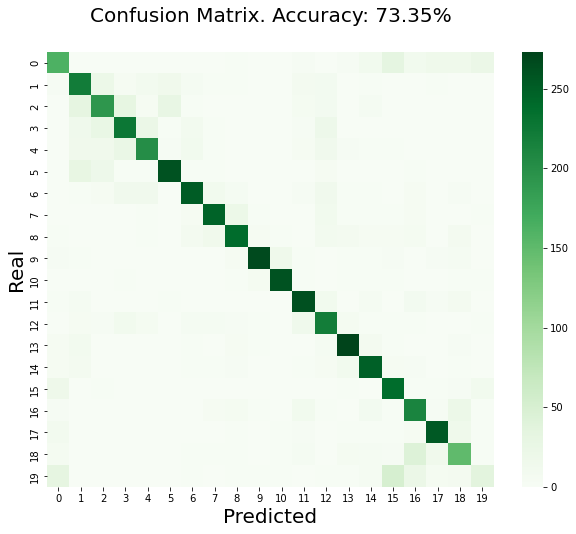

In [ ]:
model = LogisticRegression(max_iter=1000) # instantiation the model
model_fit = model.fit(train_features, train_labels) # fitting the model
predictions = model_fit.predict(test_features) # making predictions
accuracy = accuracy_score(test_labels, predictions) # predictions accuracy

plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(confusion_matrix(
    y_true = test_labels, 
    y_pred = predictions)), cmap='Greens', annot=False)
plt.xlabel('Predicted',fontsize=20)
plt.ylabel('Real',fontsize=20)
plt.title(f"Confusion Matrix. Accuracy: {round(accuracy*100,2)}%",fontsize=20,pad=30)
plt.show()